# Effect of threshold in model accuracy

This notebook shows the effect of choosing thresholds for the softmax layer in classification problems.

Model accuracy is usually reported as:

```text
     Number of correct predictions in the test set
   -------------------------------------------------
       Total number of instances in the test set
```

But how do we determine what a "correct prediction" is?

The usual approach is to choose the label that has the maximum predicted probability:

```python
    predicted_probability = model.predict(ds_test)
    predicted_label = np.argmax(predicted_probability, axis=1)
```

However, this method glosses over two important factor:

1. Two or more classes may have very close predicted probabilities.
1. Some applications require the model to be 

To address both items we need to use thresholds to decide when a prediction is correct. For example, in high-stakes applications, we may require the model to be at least 90% certain of a prediction to accept it as correct.

Using the MNIST dataset, we will investigate the effect of settings thresholds for predictions on the accuracy of models.

Sources:

- [Tensorflow MNIST example](https://www.tensorflow.org/datasets/keras_example)
- [Keras MNIST example](https://keras.io/examples/vision/mnist_convnet/)
- [Multi-label vs. Multi-class Classification: Sigmoid vs. Softmax](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)
- [Interpreting logits: sigmoid vs softmax](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax.html)

In [1]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import draw_digits as d
%matplotlib inline

To increase reproducibility (but still not guaranteed to get exactly the same results because of parallelism and GPU usages).

References:

- [Stackoverflow](https://stackoverflow.com/a/53760258)
- [Tensorflow `set_seed`](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)

In [2]:
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load MNIST and create the training/test pipelines

The code in this section is from the [TensorFlow MNIST example](https://www.tensorflow.org/datasets/keras_example).

Load MNIST.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

2023-07-08 20:43:27.509863: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/cgarbin/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Build training pipeline.

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Build test pipeline.

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Train a model

The model is a simple network that can achieve about 98-99% accuracy in a few minutes of training.

This accuracy is enough for the experiments. We are interested in the effect of using different thresholds with softmax, not on very high accuracy for the model.

In [6]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28,1)
ACTIVATION='relu'

In [7]:
# Based on https://keras.io/examples/vision/mnist_convnet/
model = tf.keras.Sequential([
    tf.keras.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation=ACTIVATION),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=ACTIVATION),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Train the model using early stopping to get a decent model without investing too much time in training. The main purpose of this notebook is not to get high accuracy. It's to demonstrate the effect of choosing thresholds for predictions.

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, verbose=1,
    restore_best_weights=True)

model.fit(
    ds_train, epochs=5,
    validation_data=ds_test,
    callbacks=[callback]
)

Epoch 1/5
469/469 [==============================] - 20s 23ms/step - loss: 0.2648 - sparse_categorical_accuracy: 0.9213 - val_loss: 0.0749 - val_sparse_categorical_accuracy: 0.9759
Epoch 2/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0854 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.0628 - val_sparse_categorical_accuracy: 0.9790
Epoch 3/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0627 - sparse_categorical_accuracy: 0.9809 - val_loss: 0.0402 - val_sparse_categorical_accuracy: 0.9871
Epoch 4/5
469/469 [==============================] - 10s 21ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0362 - val_sparse_categorical_accuracy: 0.9881
Epoch 5/5
469/469 [==============================] - 10s 22ms/step - loss: 0.0451 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.0316 - val_sparse_categorical_accuracy: 0.9890


## Analyze predictions on the test set

This section shows some digits that were correctly predicted and some that were misclassified. The goal is to visually check if the model is indeed working before proceeding with the experiments.

The actual labels and images 
from the test set.

In [9]:
test_label = np.concatenate([y for _, y in ds_test], axis=0)
test_image = np.concatenate([x for x, _ in ds_test], axis=0)

The model's predicted probabilities and labels (using the maximum predicted probability).

In [10]:
predicted_probability = model.predict(ds_test)
predicted_label = np.argmax(predicted_probability, axis=1)

# Basic sanity checks
assert len(test_label) == len(predicted_label)

79/79 [==============================] - 1s 6ms/step


Visualize some digits that were predicted correclty.

In [11]:
# Get indices of all instaces correctly classified
correct_index = [i for i in np.arange(len(predicted_label)) 
                    if predicted_label[i] == test_label[i]]

# Get indices of all misclassfied instaces
misclassified_index = [i for i in np.arange(len(predicted_label)) 
                        if predicted_label[i] != test_label[i]]

# Sanity check
assert (len(correct_index) + len(misclassified_index)) == len(test_label)

print('Found {:,} correctly classified and {:,} misclassified instances'.format(
    len(correct_index), len(misclassified_index)))

Found 9,890 correctly classified and 110 misclassified instances


Samples of correctly classified digits. The numbers above each digit show the digit index in the test set, the test label, and the (in this case, correct) predicted label.

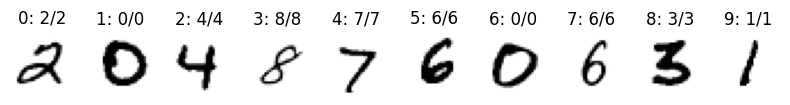

In [12]:
d.draw_digits(correct_index[:10], test_label, predicted_label, test_image)

Samples of misclassified digits. The correct and predicted labels are shown above each digit (correct/predicted).

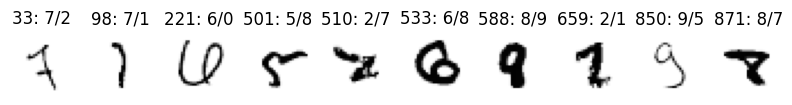

In [13]:
d.draw_digits(misclassified_index[:10], test_label, predicted_label, test_image)

## Correctly classified, by a large margin

When choosing a class, we have so far simply asked for the maximum probability:

`predicted_label = np.argmax(predicted_probability, axis=1)`

For example, here are the probabilities for one of the digits in the test set:

In [14]:
SAMPLE_DIGIT = 1
print(predicted_probability[SAMPLE_DIGIT])

[9.9998903e-01 3.4176144e-16 3.7221668e-07 1.5482250e-12 8.4599036e-16
 4.1762914e-06 3.1184502e-06 5.9961797e-12 2.9600308e-06 3.7965142e-07]


And here is what `argmax` returns:

In [15]:
print('Model predicted digit {}'.format(
    np.argmax(predicted_probability[SAMPLE_DIGIT])))

Model predicted digit 0


Here is the image, showing that it was indeed a correct prediction.

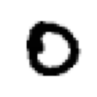

In [16]:
_, ax = plt.subplots(figsize=(1, 1))
ax.imshow(test_image[SAMPLE_DIGIT], cmap=plt.get_cmap('Greys'))
plt.axis('off');

In this case, the model is certain that this is the correct digit by orders of magnitude.

Here are the probabilities again. Compare the probability for the index that matches the prediction in the array with the probabilities for the other indices.

In [17]:
print(predicted_probability[SAMPLE_DIGIT])

[9.9998903e-01 3.4176144e-16 3.7221668e-07 1.5482250e-12 8.4599036e-16
 4.1762914e-06 3.1184502e-06 5.9961797e-12 2.9600308e-06 3.7965142e-07]


## Correctly classified, by a slimmer margin

But we also have cases where the "winning" prediction does not have such a large margin.

In this section we will review some correct classifications whose largest probability was not above 50%. This indicates that the model was not certain about the prediction.

Find the digits that have been predicted with less than 50% confidence.

In [18]:
THRESHOLD = 0.5

max_predicted_probabiliy = np.max(predicted_probability, axis=1)

probability_le_threshold = [i for i in correct_index if
                            max_predicted_probabiliy[i] <= THRESHOLD]
probability_gt_threshold = [i for i in correct_index if
                            max_predicted_probabiliy[i] > THRESHOLD]

# A few sanity checks
num_le_threshold = len(probability_le_threshold)
num_gt_threshold = len(probability_gt_threshold)
assert (num_le_threshold + num_gt_threshold) == len(correct_index)


Show some statistics.

In [19]:
num_correct_predicted = len(correct_index)
print('Out of {:,} correctly classified digit, for the {:.0%} threshold:'.format(
    num_correct_predicted, THRESHOLD))
print('  {:,} digits are above the threshold'.format(num_gt_threshold))
print('  {:,} are at or below the threshold'.format(num_le_threshold))

Out of 9,890 correctly classified digit, for the 50% threshold:
  9,879 digits are above the threshold
  11 are at or below the threshold


Visualize the probabilities the model predicted.

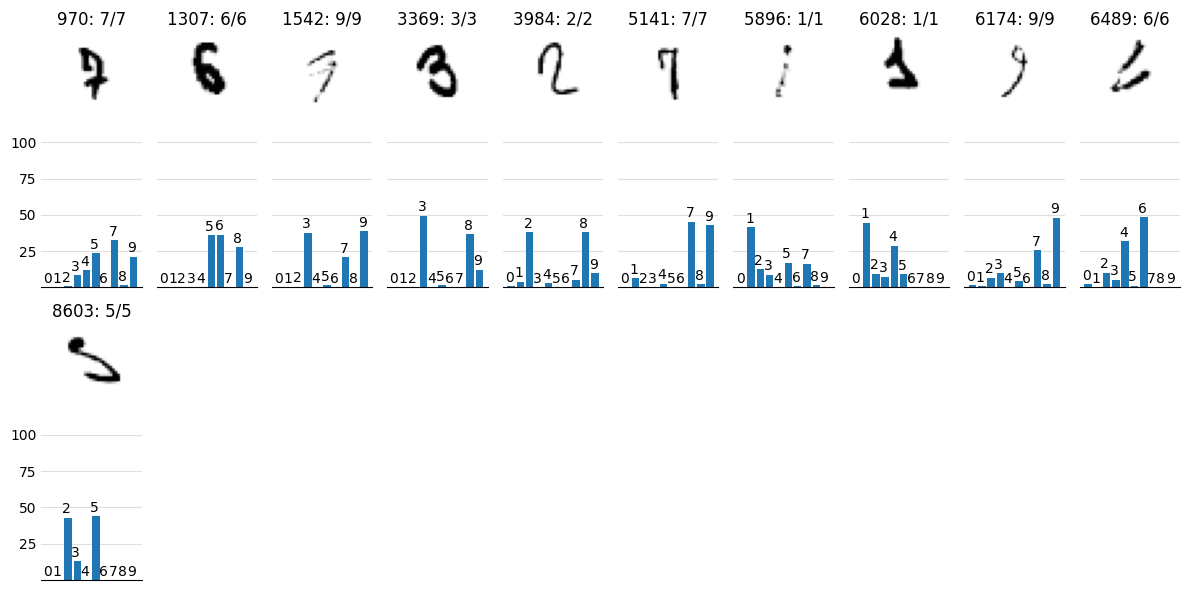

In [20]:
d.draw_digits_histogram(probability_le_threshold[:100],
    test_label, predicted_label, test_image, predicted_probability)

## Effect of different thresholds on the model accuracy

In some applications we must have a high confidence on the predictions from the model. For example, if we are reading digits from a check of process automatic deposits (or withdrawals), we want to be confident that we are processing the right amounts.

In this section we will see the effect in the model accuracy when we use different thresholds to decide what a "correct" prediction is.

First, the accuracy of the model using the maximum probability, the method we should assume is being used, unless we are explicitly told what method was used.

In [21]:
num_test_digits = len(test_label)
num_correct_max_prob = num_correct_predicted

print('Model accuracy with maximum probability: {:.2%}'.format(
    num_correct_max_prob/num_test_digits))

Model accuracy with maximum probability: 98.90%


Now, the effect of setting different thresholds.

In [22]:
def show_accuracy(threshold):
    # Calculate number of correct predictions that are below the threshold
    lt_threshold = [i for i in correct_index if
                        max_predicted_probabiliy[i] < threshold]
    # Deduct from the correct predictions that used max probability
    correct_with_threshold = num_correct_max_prob - len(lt_threshold)
    print('Model accuracy with threshold {:.2%}: {:.2%}'.format(
        threshold, correct_with_threshold/num_test_digits))

for threshold in [0.9999, 0.999, 0.99, 0.95, 0.9, 0.8, 0.75, 0.67, 0.5]:
    show_accuracy(threshold)

Model accuracy with threshold 99.99%: 46.81%
Model accuracy with threshold 99.90%: 74.56%
Model accuracy with threshold 99.00%: 90.17%
Model accuracy with threshold 95.00%: 95.23%
Model accuracy with threshold 90.00%: 96.57%
Model accuracy with threshold 80.00%: 97.69%
Model accuracy with threshold 75.00%: 97.96%
Model accuracy with threshold 67.00%: 98.33%
Model accuracy with threshold 50.00%: 98.79%


From these numbers we can see that if we want to be very confident (threshold = 99.99%), the accuracy of the model drops significantly.

As we lower the threshold of what we accept as "correct", the accuracy creeps back up.

## Accuracy in context

This shows the importance of defining what we consider to be a confident prediction. This value, the minimum confidence level we accept, varies by application.

Statements like "we achieved 99.9% accuracy on [_some task here_]" are meaningless without context.

Thus, when we see the a claim of accuracy for a model, we must ask questions to undertsand how it was measured.

1. How predictions are being made: is it probability-based (as in the examples above)? Something else?
1. What factors control the predictions: is it threshold-based or some other decision (e.g. argmax)? If it is threshold-based, what are the thresholds?

# Inspecting digits

Use this section to inspect digits and thresholds.

**IMPORTANT**: assumes that all cells above were executed. It depends on variables created in those cells.

### Inspect one digit

if you would like to view the prediction of a specific digits, enter its index in the test set below.

[9.9992466e-01 3.5795001e-16 4.1389765e-07 1.3062479e-09 8.8223225e-15
 6.2763963e-09 7.1910334e-05 2.9020107e-15 5.6870078e-07 2.4479527e-06]
Model predicted digit 0


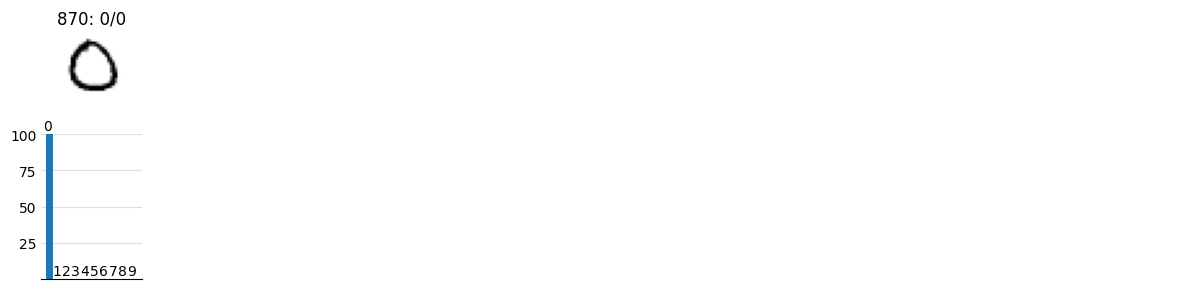

In [23]:
DIGIT_INDEX = 870
print(predicted_probability[DIGIT_INDEX])
print('Model predicted digit {}'.format(
    np.argmax(predicted_probability[DIGIT_INDEX])))
d.draw_digits_histogram([DIGIT_INDEX],
    test_label, predicted_label, test_image, predicted_probability)

### Inspect digits below or at a threshold

If you would like to view digits with a predicted probability at or below a threshold, enter the threshold below.

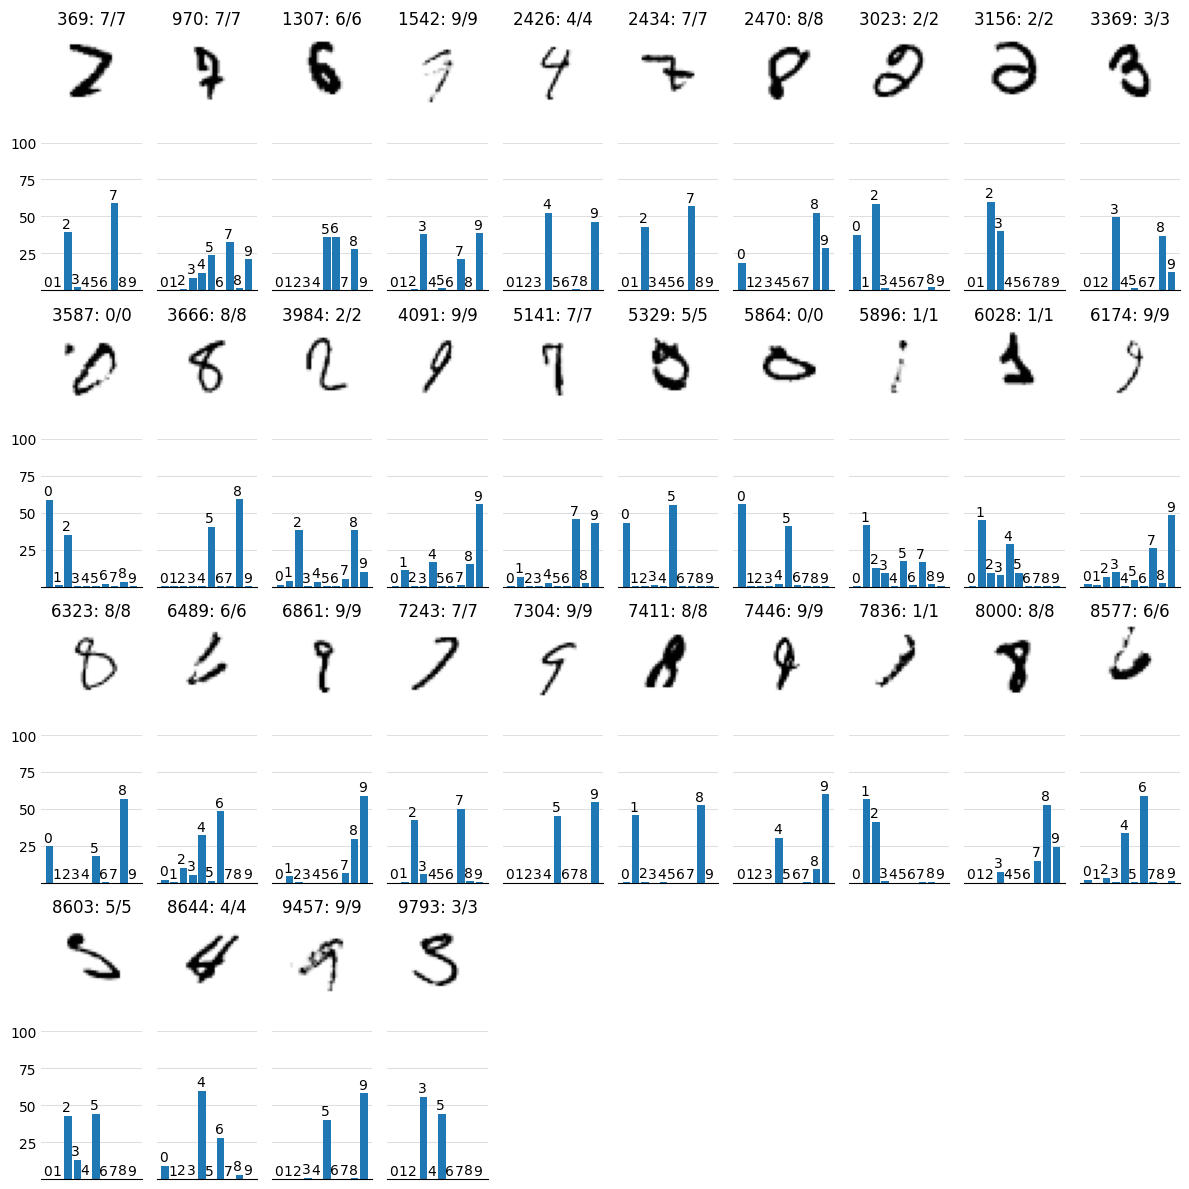

In [24]:
THRESHOLD_TO_INSPECT = 0.6

probability_le_threshold_to_inspect = [i for i in correct_index if
                            max_predicted_probabiliy[i] <= THRESHOLD_TO_INSPECT]

# Draw the digits and probabilities, if there any
if len(probability_le_threshold_to_inspect) > 0:
    # Limit the number of digits to show to not lock the notebook for a long time
    d.draw_digits_histogram(probability_le_threshold_to_inspect[:50],
        test_label, predicted_label, test_image, predicted_probability)